In [62]:
import os
import sys
# 引入日历模块
import calendar
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import baostock as bs
import tushare as ts
from datetime import datetime, timedelta
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [63]:
lg = bs.login()

login success!


In [110]:
class Transaction:
    def __init__(self, code: str, name: str):
        self.code = code
        self.name = name
        self.finised = False
        self.date = []
        self.price = []
        self.amount = []
        self.amount_buy = 0
        self.funds_cost = 0

    def trade(self, date: str, price: float, amount: int):
        if (self.finised):
            print('this trade had been turned down.')
            return
        self.date.append(date)
        self.price.append(price)
        self.amount.append(amount)
        if (amount > 0):
            self.amount_buy += amount
            self.funds_cost += price * amount
        else:
            self.finised = True

    def dump(self):
        print('\nTransactions:')
        for i in range(len(self.date)):
            print('date:%s price:%.2f amount:%d' %
                  (self.date[i], self.price[i], self.amount[i]))

    def cost(self):
        return self.funds_cost

    def cost_price(self):
        return self.funds_cost/self.amount_buy

    def profit(self, price_latest: float):
        if self.finised:
            return - self.funds_cost - \
                self.amount[len(self.amount) - 1] * \
                self.price[len(self.price) - 1]
        else:
            return price_latest * self.amount_buy - self.funds_cost

    def rate(self, price_latest: float):
        return (self.profit(price_latest) / self.cost()) * 100


def Test():
    price_latest = 23.37
    trans = Transaction('sz.000651', '格力电器')
    trans.trade('2017-01-01', 22, 100)
    trans.trade('2017-01-10', 21.2, 100)
    trans.trade('2017-02-01', 23, -200)
    print('cost  : ', trans.cost())
    print('profit: ', trans.profit(price_latest))
    print('profit_rate  : %%%.2f' % trans.rate(price_latest))
    trans.dump()


Test()

cost  :  4320.0
profit:  280.0
profit_rate  : %6.48

Transactions:
date:2017-01-01 price:22.00 amount:100
date:2017-01-10 price:21.20 amount:100
date:2017-02-01 price:23.00 amount:-200


In [118]:
def calculate(stock='sh.601398', name='工商银行', date_focus='2018-09-28', is_sim=False):
    # 获取历史90日K线数据（不包含当日） 和 当日5分钟K线数据（用来模拟当日的实时股价）
    date_beg = (datetime.strptime(date_focus, '%Y-%m-%d') -
                timedelta(days=90)).strftime('%Y-%m-%d')
    date_end = (datetime.strptime(date_focus, '%Y-%m-%d') -
                timedelta(days=1)).strftime('%Y-%m-%d')
    rs_days = \
        bs.query_history_k_data(stock,
                                "date,open,close,high,low,volume,amount,turn",
                                start_date=date_beg,
                                end_date=date_end,
                                frequency="d")
    rs_5min = \
        bs.query_history_k_data(stock,
                                "date,time,open,close,high,low,volume,amount",
                                start_date=date_focus,
                                end_date=date_focus,
                                frequency="5")
    data_days = rs_days.get_data()
    data_5min = rs_5min.get_data()
    
    # 计算历史日K的ma3/ma5/ma3-ma5
    data_days['ma3'] = np.round(
        pd.Series.rolling(data_days['close'], 3).mean(), 2)
    data_days['ma5'] = np.round(
        pd.Series.rolling(data_days['close'], 5).mean(), 2)
    data_days['ma3-ma5'] = data_days['ma3'] - data_days['ma5']
    
    # 根据当前的5分钟数据，计算当日的实时 ma3/ma5/ma3-ma5
    # -------------------------------------------
    # |          |   0   |   1   |  ...  |   47 | <-- 当日各个5分钟的点
    # -------------------------------------------
    # | ...      |  ...  |          ...         |  
    # | 20180827 | 27.01 |          ...         | 
    # | ...      |  ...  |          ...         | <-- 以上都是历史ma3(or ma5/ma3-ma5)
    # | 20180928 | 25.21 |          ...         | <-- 以当日的第i个5分钟close price
    # -------------------------------------------       计算出的ma3(or ma5/ma3-ma5)
    data_realtime_ma3_all = pd.DataFrame() 
    data_realtime_ma5_all = pd.DataFrame()
    data_realtime_ma3_ma5_all = pd.DataFrame()
    data_realtime = pd.DataFrame()
    data_realtime['date'] = data_days['date']
    data_realtime['close'] = data_days['close']
    data_realtime.loc[len(data_realtime)] = [date_focus, 0]
    num_of_5min_point  = 0
    for price in data_5min['close']:
        # print(i, price)
        # 将当日的close price设置为当前的5分钟close price
        data_realtime.loc[len(data_realtime) - 1, 'close'] = price
        data_realtime['ma3'] = np.round(pd.Series.rolling(data_realtime['close'], 3).mean(), 2)
        data_realtime['ma5'] = np.round(pd.Series.rolling(data_realtime['close'], 5).mean(), 2)
        data_realtime_ma3_all[num_of_5min_point] = data_realtime['ma3']
        data_realtime_ma5_all[num_of_5min_point] = data_realtime['ma5']
        data_realtime_ma3_ma5_all[num_of_5min_point] = \
                                        data_realtime['ma3'] - data_realtime['ma5']
        # data[['ma3', 'ma5']].plot(
        # marker='o',xticks=[18, 19, 20, 21, 22],xlim=(18,23))
        num_of_5min_point += 1

    # 绘制数据(取最近5天的数据)。
    dates_str = [date for date in data_realtime['date'].values]
    # dates = [datetime.strptime(date, '%Y-%m-%d')
    #          for date in data['date'].values]
    plot_x = dates_str[len(dates_str) - 5: len(dates_str)]
    plot_y = pd.to_numeric(
        data_realtime['close'].loc[len(data_realtime)-5:len(data_realtime)],downcast='float')
    plot_y_ma3 = data_realtime_ma3_all.loc[len(data_realtime_ma3_all)-5:
                                           len(data_realtime_ma3_all)]
    plot_y_ma5 = data_realtime_ma5_all.loc[len(data_realtime_ma5_all)-5:
                                           len(data_realtime_ma5_all)]
    plot_y_ma3_ma5 = data_realtime_ma3_ma5_all.loc[len(data_realtime_ma3_ma5_all)-5:
                                                   len(data_realtime_ma3_ma5_all)]
    # plt.plot(date_list, data_ma3_ma5[[43, 44, 45, 46, 47]].loc[18:22])
    # plt.xticks(rotation='vertical')
    # plt.plot(dates[len(dates) - 5:len(dates)], data_ma3_ma5[46].loc[18:22])
    plt.figure(figsize=(5, 8))
    plt.subplot(211)
    if (is_sim): # 绘制回测图  
        plt.plot(plot_x, plot_y_ma3[36], marker='o', label='36_ma3', color='#943126')
        plt.plot(plot_x, plot_y_ma3[35], marker='o', label='35_ma3', color='#CB4335')
        plt.plot(plot_x, plot_y_ma3[34], marker='o', label='34_ma3', color='#EC7063')
        plt.plot(plot_x, plot_y_ma5[36], marker='o', label='36_ma5', color='#1A5276')
        plt.plot(plot_x, plot_y_ma5[35], marker='o', label='35_ma5', color='#2980B9')
        plt.plot(plot_x, plot_y_ma5[34], marker='o', label='34_ma5', color='#7FB3D5')
        plt.plot(plot_x, plot_y, marker='o', label='close', color='#000000')
    else: # 绘制实际使用图像
        print('TODO')
    plt.gcf().autofmt_xdate()
    plt.legend(loc='upper left')

    plt.subplot(212)
    if (is_sim): # 回测图
        plt.plot(plot_x, plot_y_ma3_ma5[36], marker='o', label='36', color='#A04000')
        plt.plot(plot_x, plot_y_ma3_ma5[35], marker='o', label='35', color='#D35400')
        plt.plot(plot_x, plot_y_ma3_ma5[34], marker='o', label='34', color='#E59866')
        plt.plot(plot_x, plot_y_ma3_ma5[10], marker='o', label='10', color='#148F77')
        plt.plot(plot_x, plot_y_ma3_ma5[9], marker='o', label='9', color='#1ABC9C')
        plt.plot(plot_x, plot_y_ma3_ma5[8], marker='o', label='8', color='#76D7C4')
    else: # 绘制实际使用图
        print('TODO')
    plt.gcf().autofmt_xdate()
    plt.legend(loc='upper left')
    # plt.show()
    plt.savefig(stock + '_' + name + '.png', format='png', dpi=400)

    # 生成报告
    print('历史数据', date_beg, ' 至 ', date_end)
    data_days['close-open'] = \
        pd.to_numeric(data_days['close'], downcast='float') - \
        pd.to_numeric(data_days['open'], downcast='float')
    index_max = data_days['close-open'].idxmax()
    print(name, ' code:', stock)
    print("最近90天最大涨幅：%s, %%%.2f" %
          (data_days['date'][index_max],
           data_days['close-open'][index_max] /
           float(data_days['open'][index_max]) * 100))
    index_min = data_days['close-open'].idxmin()
    print('最近90天最大跌幅：%s, %%%.2f' %
          (data_days['date'][index_min],
           data_days['close-open'][index_min] /
           float(data_days['open'][index_min]) * 100))

    data_latest_13days = pd.DataFrame()
    data_latest_13days['date'] = data_days['date'].loc[len(
        data_days)-13: len(data_days)]
    data_latest_13days['open'] = data_days['open'].loc[len(
        data_days)-13: len(data_days)]
    data_latest_13days['close-open'] = data_days['close-open'].loc[len(
        data_days)-13: len(data_days)]
    index_min = data_latest_13days['close-open'].idxmin()
    index_max = data_latest_13days['close-open'].idxmax()
    print("最近13日最大涨幅：%s, %%%.2f" %
          (data_latest_13days['date'][index_max],
           data_latest_13days['close-open'][index_max] /
           float(data_latest_13days['open'][index_max]) * 100))
    print('最近13日最大跌幅：%s, %%%.2f' %
          (data_latest_13days['date'][index_min],
           data_latest_13days['close-open'][index_min] /
           float(data_latest_13days['open'][index_min]) * 100))
    if (is_sim):
        print('今日：', date_focus, '本周', datetime.strptime(
            date_focus, '%Y-%m-%d').weekday() + 1,'\n',
            data_5min[['time', 'close']].loc[[8, 9, 10, 34, 35, 36]])
    else:
        print('TODO')
    
    # 返回当日收盘价在第34+1个5分钟线的收盘价。
    return float(data_5min['close'][34]), float(data_days['close'].loc[len(data_days) - 1])

历史数据 2017-01-10  至  2017-04-09
格力电器  code: sz.000651
最近90天最大涨幅：2017-02-13, %4.35
最近90天最大跌幅：2017-03-27, %-2.54
最近13日最大涨幅：2017-03-31, %3.46
最近13日最大跌幅：2017-03-27, %-2.54
昨日收盘： 31.8100
今日： 2017-04-10 本周 1 
                  time    close
8   20170410101500000  31.6600
9   20170410102000000  31.6700
10  20170410102500000  31.6900
34  20170410135500000  31.6000
35  20170410140000000  31.7100
36  20170410140500000  31.6200
------------> Reports <------------
昨日收盘价： 31.81
总成本： 6062.0
成本价： 30.31
最新价： 31.6
+%5.7目标价： 32.03767
+%9.7目标价： 33.25007
比昨日收盘涨： %-0.66
盈亏：258/%4.26


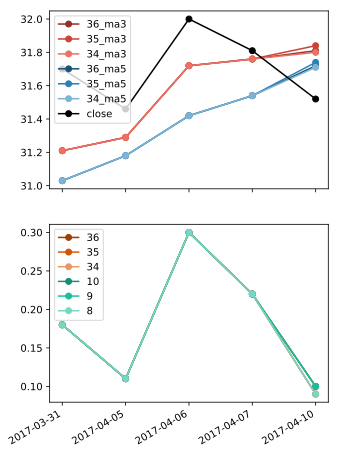

In [142]:
stock = 'sz.000651'
date_focus = '2017-04-10'
price_latest, price_close_yest = \
    calculate(stock, '格力电器', date_focus, True)

# 当前一组操作计算
hist_trans = []
trans = Transaction(stock, '格力电器')
trans.trade('2017-03-31', 30.31, 200)
print('------------> Reports <------------',)
print('昨日收盘价：', price_close_yest)
print('总成本：', trans.cost())
print('成本价：', trans.cost_price())
print('最新价：', price_latest)
print('+%5.7目标价：', trans.cost_price() * 1.057)
print('+%9.7目标价：', trans.cost_price() * 1.097)
print('比昨日收盘涨： %%%.2f' % ((price_latest - price_close_yest) / price_close_yest * 100))
print('盈亏：%d/%%%.2f' % (trans.profit(price_latest), trans.rate(price_latest)))